In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
from tqdm.notebook import tqdm
import tensorflow as tf
from multiprocessing import Process, Queue
import tensorflow.keras.layers as kl
from tensorflow import keras
from tensorflow.keras import Model
from IPython.display import clear_output

import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Do not allow tf to take the entire GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
# Mixed precision for faster training
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# XLA for faster training
tf.config.optimizer.set_jit(True)

from argparse import Namespace

config = Namespace()

n_gpus = len(tf.config.list_physical_devices(device_type='GPU'))
print('n_gpus', n_gpus)

# Paths
config.data_path = '/home/ruslan/data/datasets/KITTI_dataset/odometry/dataset/'
# config.data_path = './data/dataset/'
config.train_sequences = [
  '00', '01', '02', '03', '04', '05', '06',
  '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'
]
config.dev_sequences = ['07', '08',]
config.test_sequences = ['09', '10']

# Camera parameters
config.camera_matrix = [
    [718.856, 0,       607.1928],
    [0,       718.856, 185.2157],
    [0,       0,         1],
]
config.original_image_h = 376
config.original_image_w = 1241
config.distance_btw_cameras = 0.532331858

# Model parameters
config.backbone = 'resnet50'
config.conv_layer = 'resnet'
config.image_h = 192
config.image_w = 640
config.scale_rot = 0.01
config.scale_tr = 0.1
config.min_reprojection = 0
config.bino_depth = True
config.init_binocular_noise = 0
config.grayscale_load = False
config.grayscale_loss = False

# Training parameters
config.batch_size = 8 * n_gpus
config.num_epochs = 6
config.learning_rate = 0.0001
config.reverse_runs = False
config.lr_switch_after = 1
config.random_seed = 42
config.parallel_generation = False
config.distributed_training = n_gpus > 1
config.mixed_precision = False

# Loss parameters
config.lambda_smoothness = 0.001
config.lambda_depth_consistency = 0.1
config.occlusion_mask = False

n_gpus 1


In [2]:
import load_config
load_config.initialize(config_init=config, use_wandb=False)

from load_config import *
from data_utils import *
from models import *
from train_eval_utils import *

## Data structures

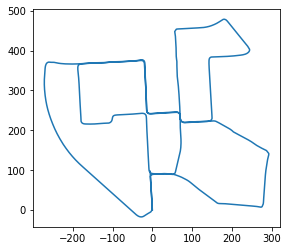

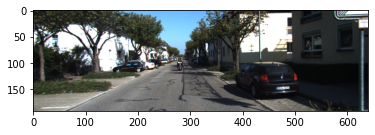

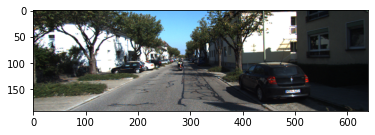

In [3]:
seq = OdoSequence('00')

seq.plot_poses()
plt.show();

plt.imshow(imread(seq.images_l[0]))
plt.show()
plt.imshow(imread(seq.images_l[1]));

## OpenCV depth estimator

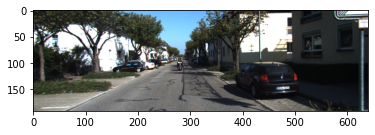

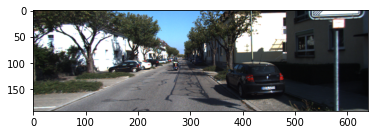

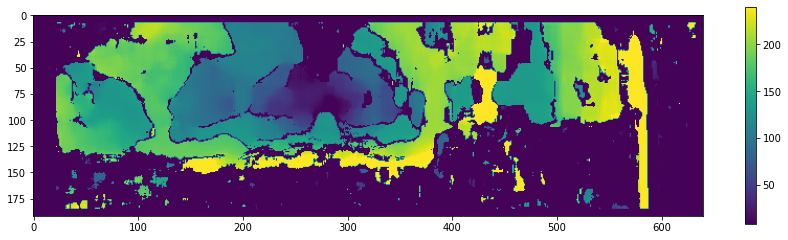

In [4]:
seq = OdoSequence('00')

img = imread(seq.images_l[0])
img_r = imread(seq.images_r[0])

plt.imshow(img)
plt.show()
plt.imshow(img_r)
plt.show()

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute((img.mean(2)*255).astype(np.uint8), (img_r.mean(2)*255).astype(np.uint8))

disparity[disparity <= 0] = 10

plt.figure(figsize=(15, 4))
plt.imshow(disparity)
plt.colorbar()
plt.show();

## Image warping

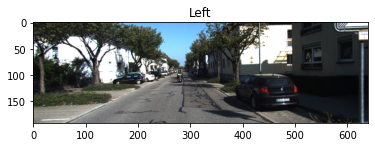

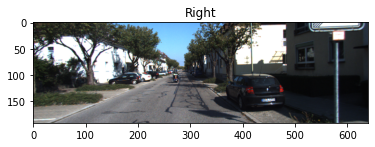

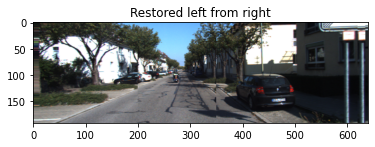

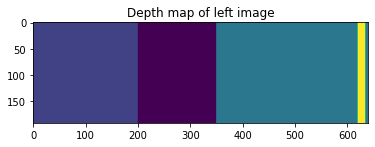

In [5]:
seq = OdoSequence('00')

img_l = tf.constant(imread(seq.images_l[0])[None], dtype=tf.float32)
img_r = tf.constant(imread(seq.images_r[0])[None], dtype=tf.float32)

# plt.figure(figsize=(15, 4))
plt.imshow(img_l[0]);
plt.title('Left')
plt.show()
# plt.figure(figsize=(15, 4))
plt.imshow(img_r[0]);
plt.title('Right')
plt.show()

# Hand-crafted depth map
depth = np.ones(img_l[0,:,:,0].shape) * 10
depth[:, :200] = 20
depth[:, 200:350] = 500
depth[:,620:635] = 4
depth = tf.constant(depth[None], dtype=tf.float32)

restored = restore_view(img_r, depth, left_right_transform)

# plt.figure(figsize=(15, 4))
plt.title('Restored left from right')
plt.imshow(restored[0]);
plt.show();

# plt.figure(figsize=(15, 4))
plt.imshow(1 / depth[0]);
plt.title('Depth map of left image')
plt.show()

## Neural network

In [22]:
from contextlib import suppress

if config.distributed_training:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    get_scope = mirrored_strategy.scope
else:
    get_scope = suppress

with get_scope():
    depth_net = DepthNet()
    pose_net = PoseNet()
    learning_rate = tf.Variable(config.learning_rate, dtype=tf.float32)
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    optimizer = mixed_precision.LossScaleOptimizer(optimizer, loss_scale='dynamic')
    
    depth_net.compile()
    pose_net.compile()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/applications/imagenet_utils.py:324: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 6 input channels.
  str(input_shape[-1]) + ' input channels.')


kernel found: conv1_conv_8/kernel:0
kernel found: conv1_conv_10/kernel:0


In [23]:
# tf.keras.utils.plot_model(pose_net, show_shapes=True)

tf.Tensor([-0.00430646  0.00766456 -0.00518567  0.03050275 -0.07912134  0.12881939], shape=(6,), dtype=float32)
(8, 192, 640, 4)


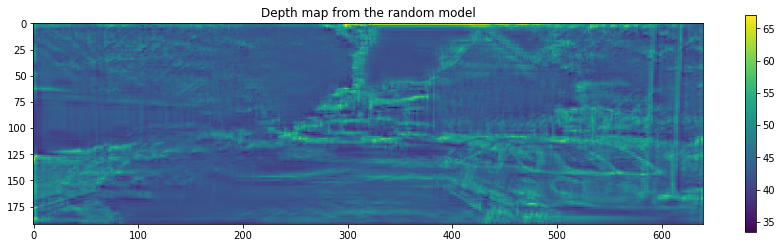

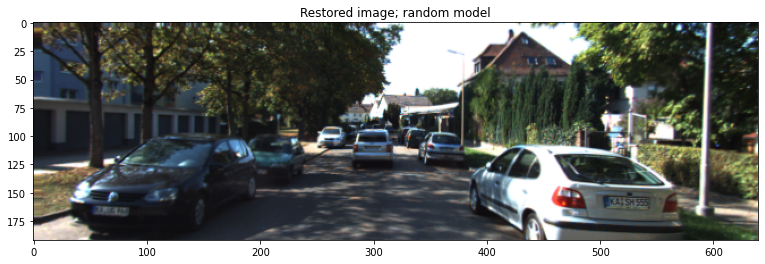

In [28]:
train_generator = BatchGenerator(config.train_sequences, shuffle=True)

for batch in train_generator:
    img_l, img_r, img_p, img_pr = batch
    break

depth = depth_net(tf.concat([img_l, img_r], 3), training=False)
pose = pose_net(tf.concat([img_l, img_r], 3), training=False)
print(pose[0])
print(depth.shape)

plt.figure(figsize=(15, 4))
plt.title('Depth map from the random model')
plt.imshow(depth[0,:,:,0].numpy().astype(float));
plt.colorbar();
plt.show()

plt.figure(figsize=(15, 4))
plt.title('Restored image; random model')
plt.imshow(restore_view(img_r, depth[:,:,:,0], rt_matrix_from_6_dof(pose))[0].numpy().astype(float));

In [ ]:
# depth_net.save('saved_models/untrained_depth')
# pose_net.save('saved_models/untrained_pose')

In [ ]:
[(v.name, v.shape) for v in pose_net.trainable_variables]

In [ ]:
train_generator = BatchGenerator(config.train_sequences, shuffle=True)

for batch in train_generator:
    img_l, img_r, img_p, img_pr = batch
    break

aug = random_augmentation(img_l.shape[0])
img_l_aug = augment(img_l, aug)
img_r_aug = augment(img_r, aug)

fig, axes = plt.subplots(len(img_l), 3, figsize=(14, 30))
axes[0, 0].set_title('Original left')
axes[0, 1].set_title('Augmented left')
axes[0, 2].set_title('Augmented right')
for i in range(len(img_l)):
    axes[i, 0].imshow(img_l[i])
    axes[i, 1].imshow(img_l_aug[i])
    axes[i, 2].imshow(img_r_aug[i])

# Training

In [ ]:
train_generator = BatchGenerator(config.train_sequences, shuffle=True)
dev_generator = BatchGenerator(config.dev_sequences)

# Training
for epoch in range(1, config.num_epochs + 1):
    print('Epoch', epoch)
    train_log = train_epoch(depth_net, pose_net, optimizer, train_generator, epoch, use_wandb=False)
    print('Training log:\n\t{}'.format(train_log))
    
    if epoch == config.lr_switch_after:
        new_lr = config.learning_rate * 0.1
        print('Changing learning rate to', new_lr)
        learning_rate.assign(new_lr)
    
    # Plot one of dev sequences
    fig, axes = plt.subplots(1, len(config.dev_sequences), figsize=(10, 10))
    for i, seq_id in enumerate(config.dev_sequences):
        poses_07 = predict_poses(pose_net, seq_id)
        seq = OdoSequence(seq_id)
        seq_pred = OdoSequence(seq_id)
        predictions_07 = [np.eye(4)]
        for transform in rt_matrix_from_6_dof(poses_07):
            predictions_07.append(predictions_07[-1] @ transform.numpy())
        seq_pred.poses = predictions_07

        axes[i].set_title('Sequence ' + seq_id)
        seq.plot_poses(ax=axes[i], label='Ground truth');
        seq_pred.plot_poses(ax=axes[i], label='Prediction');
        axes[i].legend()
    plt.show()
    # Show depth map
    seq = OdoSequence('07')
    img_l = tf.constant(imread(seq.images_l[101])[None], dtype=tf.float32)
    img_r = tf.constant(imread(seq.images_r[101])[None], dtype=tf.float32)
    plt.figure(figsize=(15, 4))
    plt.title(f'Disparity map at epoch {epoch}')
    depth = depth_net(tf.concat([img_l, img_r], 3))[:,:,:,0]
    plt.imshow(1 / depth[0].numpy().astype(float));
    plt.colorbar();
    plt.show()

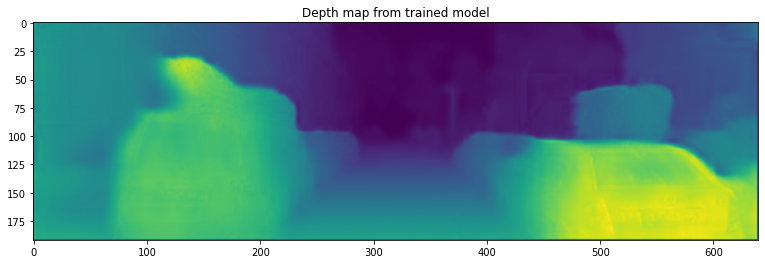

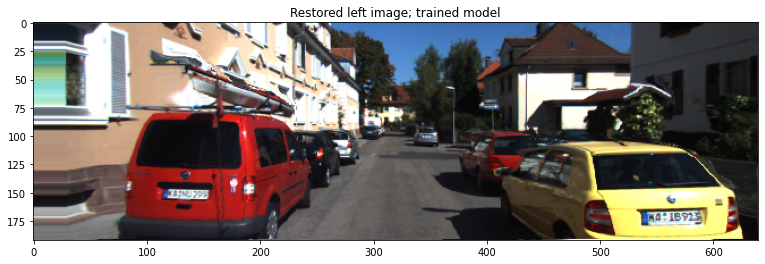

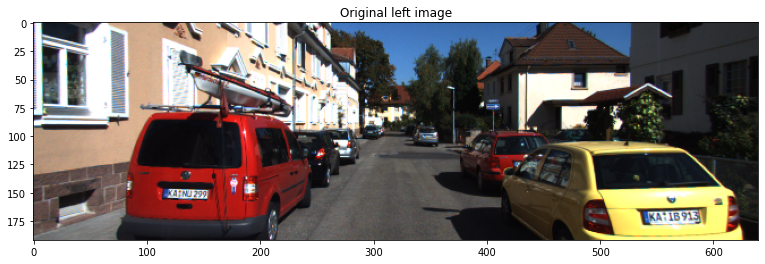

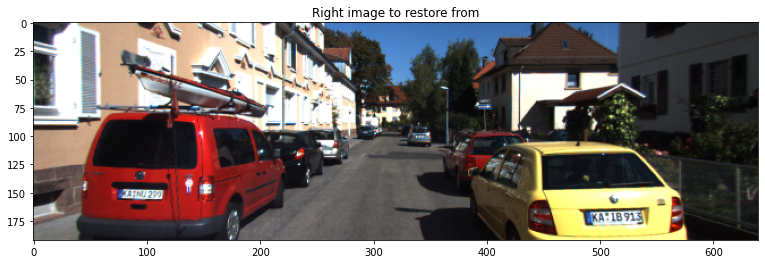

In [30]:
seq = OdoSequence('07')

img_l = tf.constant(imread(seq.images_l[101])[None], dtype=tf.float32)
img_r = tf.constant(imread(seq.images_r[101])[None], dtype=tf.float32)
img_p = tf.constant(imread(seq.images_l[100])[None], dtype=tf.float32)
img_n = tf.constant(imread(seq.images_l[102])[None], dtype=tf.float32)

plt.figure(figsize=(15, 4))
plt.title('Depth map from trained model')
depth = depth_net(tf.concat([img_l, img_r], 3))[:,:,:,0]
plt.imshow(1/depth[0].numpy().astype(float));
# plt.colorbar();
plt.show()

# pose = pose_net(tf.concat([img_l, img_n], 3))
# print(pose)

plt.figure(figsize=(15, 4))
plt.title('Restored left image; trained model')
plt.imshow(restore_view(img_r, depth, left_right_transform.astype('float32'))[0]);
plt.show()

plt.figure(figsize=(15, 4))
plt.title('Original left image')
plt.imshow(img_l[0]);
plt.show();

plt.figure(figsize=(15, 4))
plt.title('Right image to restore from')
plt.imshow(img_r[0]);
plt.show();

In [31]:
# @tf.function
# def compute_nn_occlusion_mask(cam_coords):
#     '''
#     cam_coords:
#         tf.Tensor of shape [batch, 4, h*w]
#         3D point cloud
    
#     Returns:
#     reproj_mask:
#         tf.Tensor of shape [batch, h, w]
#         Projection mask
#     '''
#     # 3D point cloud to 2D image coordinates
#     sparse_points = cam_coords[:, :2] / cam_coords[:,2:3] # [batch, 2, h*w]
#     sparse_points = tf.transpose(sparse_points, [0, 2, 1]) # [batch, h*w, 2]
#     sparse_points = tf.reshape(sparse_points, [-1, 2]) # [batch * h*w, 2]
#     sparse_x = sparse_points[:, 0:1]
#     sparse_y = sparse_points[:, 1:2]
#     # Scale to the resized image coordinates
#     sparse_x = (sparse_x + 0.5) / config.original_image_w * config.image_w - 0.5
#     sparse_y = (sparse_y + 0.5) / config.original_image_h * config.image_h - 0.5
#     # Remove out-of-frame points
#     sparse_x = tf.clip_by_value(sparse_x, 0, config.image_w - 1)
#     sparse_y = tf.clip_by_value(sparse_y, 0, config.image_h - 1)
#     # Round
#     sparse_points = tf.concat([sparse_y, sparse_x], 1) # [batch * h*w, 2]
#     sparse_points = tf.concat([
#             tf.cast(sparse_points, tf.int32),
#             tf.cast(sparse_points + 0.5, tf.int32)
#         ], 0) # [batch * h*w * 2, 2]
#     # Add batch index
#     sparse_points = tf.concat([
#             tf.tile(tf.range(cam_coords.shape[0]), [cam_coords.shape[2] * 2])[:, None],
#             sparse_points
#         ], 1) # [batch * h*w * 2, 3]
#     # Make sparse tensor
#     sparse_points = tf.sparse.SparseTensor(
#         tf.cast(sparse_points, tf.int64),
#         tf.ones(shape=[sparse_points.shape[0]]),
#         [cam_coords.shape[0], config.image_h, config.image_w],
#     )
#     # Convert to dense tensor
#     proj_mask = tf.sparse.to_dense(sparse_points, validate_indices=False)
    
#     return proj_mask

def compute_s2_occlusion_mask(warp):
    # Random image
    noise_channels = 10
    noise = tf.random.normal(shape=[warp.shape[0], config.image_h, config.image_w, noise_channels])
    noise = tfa.image.dense_image_warp(noise, -warp)
    # Gradients
    noise_edges = tf.image.sobel_edges(noise)
    noise_edges_norm = tf.sqrt(tf.reduce_sum(noise_edges**2, 4, keepdims=True))
    noise_edges = noise_edges / noise_edges_norm
    # Average squared cosine between gradients on different channels
    mul_1 = tf.reshape(noise_edges, [-1, config.image_h, config.image_w, noise_channels, 1, 2])
    mul_2 = tf.reshape(noise_edges, [-1, config.image_h, config.image_w, 1, noise_channels, 2])
    mean_cos2 = tf.reduce_mean(
        tf.reduce_sum(mul_1 * mul_2, 5)**2,
        [3, 4])
    # Nematic order parameter S2
    s2 = 3/2 * mean_cos2 - 0.5
    # To binary mask
    mask = tf.cast(s2 > 0.9, tf.int32)
    # Apply dilation
    mask = tf.nn.dilation2d(
        mask[:,:,:,None],
        filters=tf.zeros((3,3,1), dtype=tf.int32),
        strides=(1,1,1,1),
        data_format='NHWC',
        dilations=(1,1,1,1),
        padding="SAME")[:,:,:,0]
    # Convert to float {0., 1.}
    mask = 1 - tf.cast(mask, warp.dtype)
    return mask

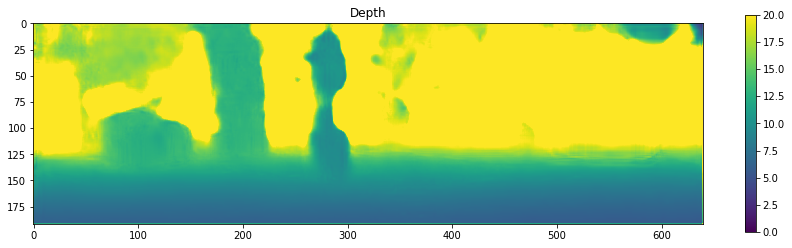

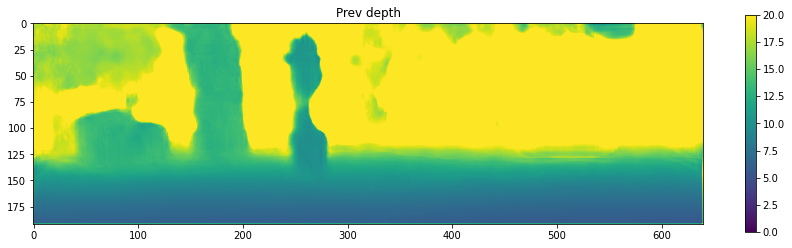

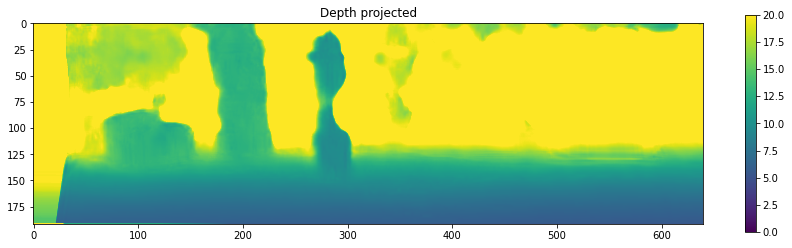

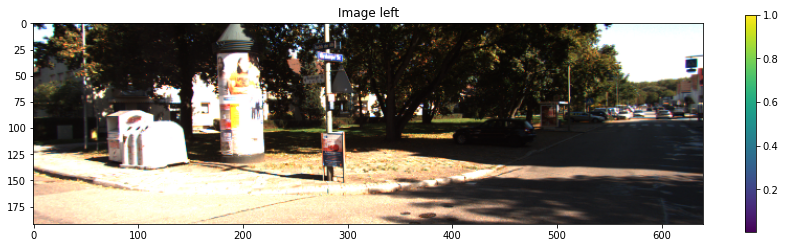

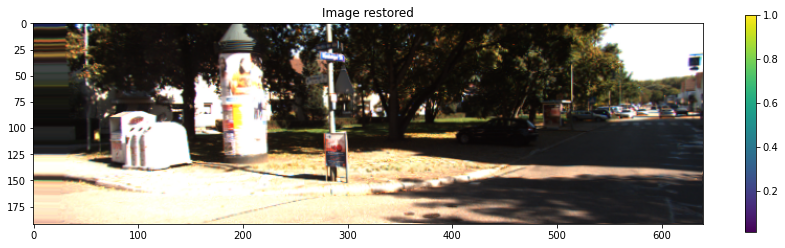

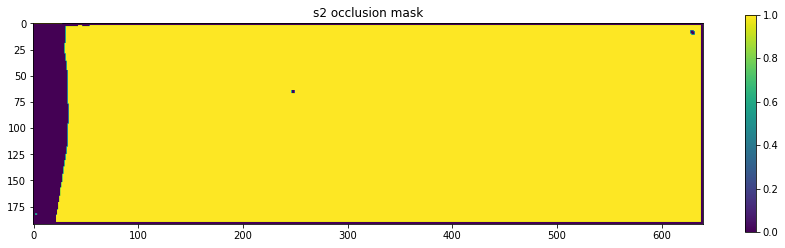

In [32]:
seq = OdoSequence('08')
idx = 62

img_l = tf.constant(imread( seq.images_l[idx])[None], dtype=tf.float32)
img_r = tf.constant(imread( seq.images_r[idx])[None], dtype=tf.float32)
img_p = tf.constant(imread( seq.images_l[idx - 1])[None], dtype=tf.float32)
img_pr = tf.constant(imread(seq.images_r[idx - 1])[None], dtype=tf.float32)

img_r_orig = img_r
img_p_orig = img_p

pose = pose_net(tf.concat([img_l, img_p], 3))
prev2left_transform = rt_matrix_from_6_dof(pose)
left2prev_transform = rt_matrix_from_6_dof(-pose)
depth = depth_net(tf.concat([img_l, img_r], 3))[:,:,:,0]
depth_p = depth_net(tf.concat([img_p, img_pr], 3))[:,:,:,0]

# Restore previous depth from the current depth
_, cam_coords = get_warp(depth_p, left2prev_transform)
restored_depth = tf.reshape(cam_coords[:, 2], depth.shape)
warp, _ = get_warp(depth, prev2left_transform)
restored_depth = tfa.image.dense_image_warp(restored_depth[:,:,:,None], -warp)[:,:,:,0]
# Restore left image from the previous image
restored_p = tfa.image.dense_image_warp(img_p_orig, -warp)

# Reprojection mask
# reproj_mask = compute_projection_mask(cam_coords)
# reproj_mask = blur_image(reproj_mask[:, :, :, None])[:,:,:,0] > 0.8
# reproj_mask = tf.cast(reproj_mask, depth.dtype)
s2_occlu_mask = compute_s2_occlusion_mask(warp)
# fw_occlu_mask = compute_fw_occlusion_mask(warp)

plt.figure(figsize=(15, 4))
plt.title('Depth')
plt.imshow(depth[0], vmin=0, vmax=20);
plt.colorbar();

plt.figure(figsize=(15, 4))
plt.title('Prev depth')
plt.imshow(depth_p[0], vmin=0, vmax=20);
plt.colorbar();

plt.figure(figsize=(15, 4))
plt.title('Depth projected')
plt.imshow(restored_depth[0], vmin=0, vmax=20);
plt.colorbar();

# plt.figure(figsize=(15, 4))
# plt.title('Depth error')
# plt.imshow((tf.abs(1 / restored_depth - 1 / depth) * reproj_mask)[0]);
# plt.colorbar();

plt.figure(figsize=(15, 4))
plt.title('Image left')
plt.imshow(img_l[0]);
plt.colorbar();

plt.figure(figsize=(15, 4))
plt.title('Image restored')
plt.imshow(restored_p[0]);
plt.colorbar();

plt.figure(figsize=(15, 4))
plt.title('s2 occlusion mask')
plt.imshow(s2_occlu_mask[0]);
plt.colorbar();

In [53]:
def get_grid(x):
    batch_size, height, width, filters = tf.unstack(tf.shape(x))
    Bg, Yg, Xg = tf.meshgrid(tf.range(batch_size), tf.range(height), tf.range(width),
                             indexing = 'ij')
    # return indices volume indicate (batch, y, x)
    # return tf.stack([Bg, Yg, Xg], axis = 3)
    return Bg, Yg, Xg # return collectively for elementwise processing

def bilinear_warp(x, flow):
    _, h, w, _ = tf.unstack(tf.shape(x))
    grid_b, grid_y, grid_x = get_grid(x)
    grid_b = tf.cast(grid_b, tf.float32)
    grid_y = tf.cast(grid_y, tf.float32)
    grid_x = tf.cast(grid_x, tf.float32)

    fx, fy = tf.unstack(flow, axis = -1)
    fx_0 = tf.floor(fx)
    fx_1 = fx_0+1
    fy_0 = tf.floor(fy)
    fy_1 = fy_0+1

    # warping indices
    h_lim = tf.cast(h-1, tf.float32)
    w_lim = tf.cast(w-1, tf.float32)
    gy_0 = tf.clip_by_value(grid_y + fy_0, 0., h_lim)
    gy_1 = tf.clip_by_value(grid_y + fy_1, 0., h_lim)
    gx_0 = tf.clip_by_value(grid_x + fx_0, 0., w_lim)
    gx_1 = tf.clip_by_value(grid_x + fx_1, 0., w_lim)
    
    g_00 = tf.cast(tf.stack([grid_b, gy_0, gx_0], axis = 3), tf.int32)
    g_01 = tf.cast(tf.stack([grid_b, gy_0, gx_1], axis = 3), tf.int32)
    g_10 = tf.cast(tf.stack([grid_b, gy_1, gx_0], axis = 3), tf.int32)
    g_11 = tf.cast(tf.stack([grid_b, gy_1, gx_1], axis = 3), tf.int32)

    # gather contents
    x_00 = tf.gather_nd(x, g_00)
    x_01 = tf.gather_nd(x, g_01)
    x_10 = tf.gather_nd(x, g_10)
    x_11 = tf.gather_nd(x, g_11)

    # coefficients
    c_00 = tf.expand_dims((fy_1 - fy)*(fx_1 - fx), axis = 3)
    c_01 = tf.expand_dims((fy_1 - fy)*(fx - fx_0), axis = 3)
    c_10 = tf.expand_dims((fy - fy_0)*(fx_1 - fx), axis = 3)
    c_11 = tf.expand_dims((fy - fy_0)*(fx - fx_0), axis = 3)

    return c_00*x_00 + c_01*x_01 + c_10*x_10 + c_11*x_11

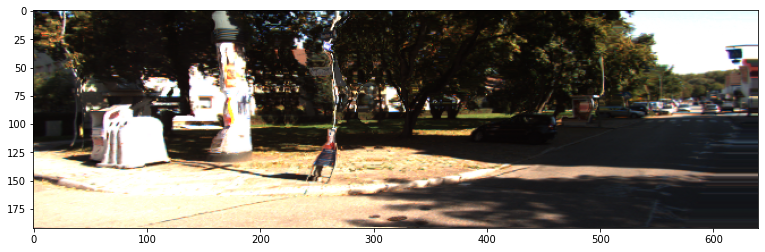

In [65]:
for i in range(10):
    # Predict pose
    rotation = tf.constant([[0, 0, 0.]], dtype=depth.dtype) / 180 * np.pi * i / 9 # [batch, 3]
    translation = tf.constant([[1., 0, 0]], dtype=depth.dtype) * i / 9 # [batch, 3]
    # Make rotation matrix
    rotation = rotation_matrix_from_euler(rotation) # [batch, 3, 3]
    # Make rotation-translation matrix
    rt_matrix = tf.concat([rotation, translation[:, :, None]], axis=2) # [batch, 3, 4]
    newline = tf.concat([
            tf.zeros_like(rt_matrix)[:, :1, :3],
            tf.ones_like(rt_matrix)[:, :1, :1]
            ], axis=2) # [batch, 1, 4]
    rt_matrix = tf.concat([rt_matrix, newline], axis=1) # [batch, 4, 4]
    
    # Get the warping vector field
    warp, _ = get_warp(depth, rt_matrix)
    # Warp
    view = bilinear_warp(img_l, warp[:,:,:,::-1])
    
    plt.figure(figsize=(15, 4))
    plt.imshow(view[0]);
    plt.show();
    
    clear_output(wait=True)

In [ ]:
seq_id = '10'
poses, poses_tuned = predict_poses(pose_net, seq_id, True, depth_net)

In [ ]:
seq = OdoSequence(seq_id)
seq_pred = OdoSequence(seq_id)
seq_pred_tuned = OdoSequence(seq_id)

# Integrate predicitons
predictions = [np.eye(4)]
for transform in rt_matrix_from_6_dof(poses):
    predictions.append(predictions[-1] @ transform.numpy())
predictions_tuned = [np.eye(4)]
for transform in rt_matrix_from_6_dof(poses_tuned):
    predictions_tuned.append(predictions_tuned[-1] @ transform.numpy())

seq_pred.poses = predictions
seq_pred_tuned.poses = predictions_tuned

fig, ax = plt.subplots(figsize=(8, 8))
ax.annotate(
    'Seq. ' + seq_id,
    xy=(0, 1), xytext=(12, -12), va='top',
    xycoords='axes fraction', textcoords='offset points',
    bbox=dict(facecolor='none', edgecolor='black'))
ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$z$ (m)')
view='xz'
seq.plot_poses(ax=ax, view=view, label='Ground truth', color='black', ls='--');
seq_pred.plot_poses(ax=ax, view=view, label='Prediction', alpha=0.8);
seq_pred_tuned.plot_poses(ax=ax, view=view, label='Prediction + GD', alpha=0.8);
ax.legend(loc="lower right");

In [ ]:
print('Prediction:')
pprint(eval_odometry(seq, seq_pred))
print()
print('Prediction+GD:')
pprint(eval_odometry(seq, seq_pred_tuned))

In [ ]:
import time

transform = tf.constant([[0, 0, 0, 0, 0, -1]], dtype=tf.float32)
# transform = pose_net(tf.concat([img_l, img_p], 3))
# Gradient descent on this transform
transform = tf.Variable(transform.numpy(), trainable=True, dtype=tf.float32)
depth = depth_net(tf.concat([img_l, img_r], 3))[:,:,:,0]
depth = tf.Variable(depth.numpy(), trainable=True, dtype=tf.float32)

optimizer = tf.keras.optimizers.Adam(lr=0.01)

for i in range(10):
    with tf.GradientTape() as tape:
        restored_p = generate_view(img_l, depth, rt_matrix_from_6_dof(transform))
        loss = per_pixel_loss(img_p, [restored_p]) + 0.001 * get_smooth_loss(depth, img_l)
#         loss = tf.reduce_mean(tf.abs(blur_image(img_p, 15) - blur_image(restored_p, 15)))
    gradient_t, gradient_d = tape.gradient(loss, [transform, depth])
#     gradient_t = gradient_t * tf.constant([[0.01, 0.01, 0.01, 1, 1, 1]], dtype=tf.float32)
    optimizer.apply_gradients([(gradient_t, transform), (gradient_d, depth)])
    
    fig, axes = plt.subplots(4, figsize=(12, 12))
    axes[0].imshow(img_l[0])
    axes[1].imshow(img_p[0])
    axes[2].imshow(restored_p[0])
    im = axes[3].imshow(1 / depth[0])
    plt.colorbar(im)
#     axes[3].imshow(tf.reduce_mean(tf.abs(blur_image(img_p, 15) - blur_image(restored_p, 15)), 3)[0])
    plt.show()
    print(transform)
    clear_output(wait=True)

In [ ]:
depth_net.save('saved_models/10h_depth_net')
pose_net.save('saved_models/10h_pose_net')

In [ ]:
!CUDA_VISIBLE_DEVICES="" python3 -m tf2onnx.convert --saved-model saved_models/10h_pose_net --output saved_models/pose_net.onnx --opset 10
print()
!CUDA_VISIBLE_DEVICES="" python3 -m tf2onnx.convert --saved-model saved_models/10h_depth_net --output saved_models/depth_net.onnx --opset 10

In [29]:
depth_net = tf.keras.models.load_model('wandb/run-20200705_095248-kksn6tbc/depth_net')
pose_net = tf.keras.models.load_model('wandb/run-20200705_095248-kksn6tbc/pose_net')